In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics as sk_metrics
from sklearn.metrics import classification_report

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch
import metrics
from torch.nn import functional as F
import config_bayesian as cfg




In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [3]:
print(torch.cuda.device_count())
print(torch.version.cuda) 

1
11.6


### Calculate uncertainties
Load the model from checkpoint and test on testset

Model performances: 
| checkpoint  | model type  | train acc  | val acc during train | epochs  | lr | train ens  | AUC | acc during validation| note  |
|-------------|-------------|------------|----------|---------|----|------------|-----|-------|-------|
| model_lenet_lrt_relu_2023-10-17_GLXXT.pt  |  lenet |  42.20 | 23.71  | 25 | 0.0005  | 10 |  |  | | |
|  model_alexnet_lrt_relu_2023-10-17_MKM9G.pt |  alexnet |  51.19 | 46.49  | 30  | 0.001 | 10 |  |  | |
| model_alexnet_lrt_relu  | alexnet  |   |   |   |  |  |  |  | |
| model_alexnet_lrt_relu_2023-10-04.pt| alexnet |  |  |  |  |  | 54.25 |  | really good for normal, not so good for the other classes |
| model_alexnet_lrt_relu_2023-10-12.pt | alexnet |  |  |  |  |  |  |  | |
| model_alexnet_lrt_relu_2023-10-12_5RM1H.pt |  |  |  |  |  |  |  |  | |
| model_alexnet_lrt_relu_2023-10-12_CVY8G |  |  |  |  |  |  |  |  | |
| model_alexnet_lrt_relu_2023-10-17_9TLBE | alexnet | 55.32 | 49.40 | 30 | 0.001 | 10 | 60.00 |  | |
| model_alexnet_lrt_relu_2023-10-17_TGK46 | alexnet |  |  | 20 | 0.0005 | 10 | 63.48 |  | really really bad for benign |
| model_custom_bbb_relu_2023-10-19_5P1A8 | custom CNN | 59.26 | 41.59 | 10 | 0.00005 | 15 | 60.38 | | input size 128x128, no augmentation |
| model_custom_bbb_relu_2023-10-19_2VP1X | custom CNN | 57.44 | 50.24 | 10 | 0.00005 | 15 | 66.43 | 57.82 | input size 128x128, no augmentation |
| model_custom_bbb_relu_2023-10-19_6GY7W | custom CNN | 56.52 | 53.23 | 10 | 0.00005 | 15 | 55.42 | 53.30 |  input size 128x128, no augmentation |
| model_custom_bbb_relu_2023-10-19_CLQSR | custom CNN | 58.45 | 51.03 | 15 | 0.00005 | 15 | 60.04  | 54.80 | input size 128x128, no augmentation  |
| model_custom_bbb_relu_2023-10-19_NTQ4K | custom CNN | 60.35 | 56.96 | 40 | 0.00001 | 15 | 70.05 | 54.24 | input size 128x128, no augmentation  |
| model_custom_bbb_relu_2023-10-23_MR25V | custom | 55.08 | 54.56 | 40 | 0.00005 | 15 | 61.04 | 50.47 |  | 128x128, with augmentation|
| model_custom_bbb_relu_2023-10-23_N8NK6 | custom |  |  | 30 | 0.0001 | 25 |  |  | 128x128, with augmentation |
| model_custom_bbb_relu_2023-10-30_YFHE7 | custom | 58.37 | 60.81 | 40 | 0.00001 | 20 | 65.94 | 59.32 | 128, augmentation |
| model_custom_bbb_relu_2023-10-30_1OK53 | custom | 55.54 | 57.09 | 6 | 0.0001 | 10 | 65.32 | 53.86 | 180, augmentation |
| model_custom_bbb_relu_2023-10-30_D6LJA | custom | 54.46 | 58.79 | 16 | 0.00005 | 10 | 58.10 | 58.19 | 180, augmentation|
| model_custom_bbb_relu_2023-10-30_ASX7D | custom | 52.05 | 59.19 | 18 | 0.00005 | 15 |  |  | |
|  |  |  |  |  |  |  |  |  | |
|  |  |  |  |  |  |  |  |  | |
|  |  |  |  |  |  |  |  |  | |
|  |  |  |  |  |  |  |  |  | |
|  |  |  |  |  |  |  |  |  | |
|  |  |  |  |  |  |  |  |  | |

In [4]:
source = cfg.source # 0: work computer, 1: laptop 

In [5]:
# Load data
trainset, testset, inputs, num_classes = data.getDataset('POCUS')
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

#ckpt_name = 'model_custom_bbb_relu_2023-10-19_2VP1X'
#ckpt_name = 'model_custom_bbb_relu_2023-12-18_C2Z4M'
ckpt_name = 'model_custom_bbb_relu_2023-12-18_AUY8G'
net_type = 'custom' # 'alexnet'

loc_pc = '/home/marisa/Documents'
loc_lap = 'C:/Users/maris/Documents/Thesis'
locs = [loc_pc, loc_lap]
loc = locs[source]

# Load model
ckpt = f'{loc}/PyTorch-BayesianCNN/checkpoints/newDataSet/POCUS/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type
try:
    imgsize = torch.load(ckpt, map_location=device)["imgsize"]
except:
    imgsize = cfg.imgsize

net = getModel(net_type, inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type, imgsize=imgsize)
net = net.to(device)
net.load_state_dict(torch.load(ckpt, map_location=device)["model_state_dict"])
net.train() # should this be train or eval?


found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Train/  :  1236
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/GE_Test/  :  531


BBBCustom(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): BBBConv2d()
  (act5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (fc1): BBBLinear()
  (act6): ReLU()
  (fc2): BBBLinear()
)

In [6]:
def evaluate_uncertainties(model):

    n_samples = len(testset)
    #n_samples = 3
    uncertainties = []

    preds = []
    truths = []
    epi_norms = []
    ale_norms = []
    epi_softs = []
    ale_softs = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=25, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=25, normalized=False)
        
        #print('epistemic norm: ', epi_norm)
        #print('aleatoric norm: ', ale_norm)
        #print('epistemic soft: ', epi_soft)
        #print('aleatoric soft: ', ale_soft)

        preds.append(pred)
        truths.append(truth)
        epi_norms.append(epi_norm)
        ale_norms.append(ale_norm)
        epi_softs.append(epi_soft)
        ale_softs.append(ale_soft)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[pred], ale_norm[pred], epi_soft[pred], ale_soft[pred], truth==pred, truth, pred])

    # save the uncertainties, predictions and truths in npy files
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_preds.npy', preds)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_truths.npy', truths)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_epi_norms.npy', epi_norms)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_ale_norms.npy', ale_norms)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_epi_softs.npy', epi_softs)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_ale_softs.npy', ale_softs)

    # balanced accuracy
    acc = sk_metrics.balanced_accuracy_score(truths, np.argmax(preds, axis=1))  
    print('Balanced accuracy: ', acc)

    unbala_acc = sk_metrics.accuracy_score(truths, np.argmax(preds, axis=1))
    print('Unbalanced accuracy: ', unbala_acc)

    acc_o = np.mean(np.argmax(preds, axis=1) == truths)
    print('Accuracy: ', acc_o)

    return uncertainties


In [7]:
uncertainties = evaluate_uncertainties(net)

Balanced accuracy:  0.4223986544519376
Unbalanced accuracy:  0.4896421845574388
Accuracy:  0.4896421845574388


### uncertainties on OOD Data

In [8]:
trainset_cca, testset_cca, _, _ = data.getDataset('OOD_CCA_US')
trainset_combo, testset_combo, _, _ = data.getDataset('OOD_combo')
_, testset_mnist, _, _ = data.getDataset('MNIST')


found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/CCA_US/OOD/  :  84
length of train set:  84
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/CCA_US/OOD/  :  84
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/  :  531
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/  :  531
length of OOD set:  531
length of MNIST test set:  10000


In [9]:
def evaluate_uncertainties(model, dataset):

    print('Evaluating uncertainties for dataset: ', dataset)

    # load dataset
    if dataset == 'CCA':
        testset = testset_cca
    elif dataset == 'combo':
        testset = testset_combo
    elif dataset == 'MNIST':
        testset = testset_mnist
    else:
        print('Dataset not found')


    n_samples = len(testset)

    preds = []
    truths = []
    epi_norms = []
    ale_norms = []
    epi_softs = []
    ale_softs = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=25, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=25, normalized=False)

        preds.append(pred)
        truths.append(truth)
        epi_norms.append(epi_norm)
        ale_norms.append(ale_norm)
        epi_softs.append(epi_soft)
        ale_softs.append(ale_soft)

    # save the uncertainties, predictions and truths in npy files
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_preds_{dataset}.npy', preds)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_truths_{dataset}.npy', truths)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_epi_norms_{dataset}.npy', epi_norms)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_ale_norms_{dataset}.npy', ale_norms)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_epi_softs_{dataset}.npy', epi_softs)
    np.save(f'{loc}/PyTorch-BayesianCNN/uncertainties/BNN_VI_{ckpt_name}_ale_softs_{dataset}.npy', ale_softs)

    # balanced accuracy
    acc = sk_metrics.balanced_accuracy_score(truths, np.argmax(preds, axis=1))  
    print('Balanced accuracy: ', acc)

    unbala_acc = sk_metrics.accuracy_score(truths, np.argmax(preds, axis=1))
    print('Unbalanced accuracy: ', unbala_acc)


In [10]:
evaluate_uncertainties(net, 'CCA')
evaluate_uncertainties(net, 'combo')
evaluate_uncertainties(net, 'MNIST')

Evaluating uncertainties for dataset:  CCA


/home/marisa/anaconda3/envs/torch4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Balanced accuracy:  0.11904761904761904
Unbalanced accuracy:  0.11904761904761904
Evaluating uncertainties for dataset:  combo
Balanced accuracy:  0.3365365484121717
Unbalanced accuracy:  0.3879472693032015
Evaluating uncertainties for dataset:  MNIST
Balanced accuracy:  0.13384809358637423
Unbalanced accuracy:  0.1471


------------------------------------

old stuff below

In [10]:
def evaluate_uncertainties2(net, testset=testset):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=32, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=32, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[0], 
                              epi_norm[1],
                              epi_norm[2],
                              ale_norm[0],
                              ale_norm[1],
                              ale_norm[2], 
                              epi_soft[0], 
                              epi_soft[1], 
                              epi_soft[2], 
                              ale_soft[0], 
                              ale_soft[1], 
                              ale_soft[2], 
                              epi_norm[pred],
                              ale_norm[pred],
                              epi_soft[pred],
                              ale_soft[pred],
                              truth==pred, 
                              truth, 
                              pred
                              ])


    return uncertainties

In [11]:
uncertainties2 = evaluate_uncertainties2(net)

In [12]:
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and worng predictions there are for each class
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in uncertainties:
    if i[4]:
        right[int(i[5])] += 1
    else:
        wrong[int(i[5])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])

print("------------------------------------------")

# check how often which label was predicted and how often it was correct
pred = [0 for i in range(num_classes)]
correct = [0 for i in range(num_classes)]
for i in uncertainties:
    pred[int(i[6])] += 1
    if i[4]:
        correct[int(i[6])] += 1

for i in range(num_classes):
    print('Class', i, ' - Prediction ', class_names[i] , ' - ', 'Predicted:', pred[i], ' , ', 'of which were correct:', correct[i])

Class 0  -  Normal  -  Right: 0  ,  Wrong: 0
Class 1  -  Benign  -  Right: 0  ,  Wrong: 3
Class 2  -  Malignant  -  Right: 0  ,  Wrong: 0
------------------------------------------
Class 0  - Prediction  Normal  -  Predicted: 3  ,  of which were correct: 0
Class 1  - Prediction  Benign  -  Predicted: 0  ,  of which were correct: 0
Class 2  - Prediction  Malignant  -  Predicted: 0  ,  of which were correct: 0


### Uncertainties and Accuracies together

In [11]:
# do a combined function that calculates uncertainties and accuracies at once and store it all together in a dataframe

def uq_acc(net, criterion, testset, beta_type=0.1, epoch=None, num_epochs=None, T=30):
    
    net.eval()
    print('number of images: ', len(testset))

    df = [] # store per image: prediction, true label, loss, accuracy, epistemic uncertainty, aleatoric uncertainty

    for i in range(len(testset)):
        input_image, label = testset[i]
        input_image = input_image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)
   
        kl = 0.0
        outputs = torch.zeros(1, net.num_classes, T).to(device)
        for j in range(T):
            net_out, _kl = net(input_image)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        kl = kl / T
        pred = torch.mean(outputs, dim=2)
        log_outputs = utils.logmeanexp(outputs, dim=2)
        outputs = outputs.squeeze(0)

        # calculate loss and accuarcy
        beta = metrics.get_beta(i-1, len(testset), beta_type, epoch, num_epochs)
        loss = criterion(log_outputs, label, kl, beta).item()
        acc = metrics.acc(log_outputs, label)


        # normalized uncertainties
        prediction = F.softplus(outputs)
        p_hat_n = prediction / torch.sum(prediction, dim=1).unsqueeze(1)

        p_hat_n = p_hat_n.detach().cpu().numpy()
        p_bar_n = np.mean(p_hat_n, axis=0)

        temp_n = p_hat_n - np.expand_dims(p_bar_n, 0)
        epistemic_n = np.dot(temp_n.T, temp_n) / T
        epistemic_n = np.diag(epistemic_n)

        aleatoric_n = np.diag(p_bar_n) - (np.dot(p_hat_n.T, p_hat_n) / T)
        aleatoric_n = np.diag(aleatoric_n)

        # softmax uncertainties
        p_hat_s = F.softmax(outputs)
        
        p_hat_s = p_hat_s.detach().cpu().numpy()
        p_bar_s = np.mean(p_hat_s, axis=0)

        temp_s = p_hat_s - np.expand_dims(p_bar_s, 0)
        epistemic_s = np.dot(temp_s.T, temp_s) / T
        epistemic_s = np.diag(epistemic_s)

        aleatoric_s = np.diag(p_bar_s) - (np.dot(p_hat_s.T, p_hat_s) / T)
        aleatoric_s = np.diag(aleatoric_s)

        pred = pred.detach().cpu().numpy()
        pred = int(np.argmax(pred))
        label = int(label.detach().cpu().numpy())

        # save to dataframe
        df.append([pred, label, loss, acc, epistemic_n[pred], aleatoric_n[pred], epistemic_s[pred], aleatoric_s[pred]])

    return df

In [12]:
criterion = metrics.ELBO(len(testset)).to(device)
df_raw = uq_acc(net, criterion, testset, beta_type=0.1, epoch=None, num_epochs=None, T=25)

number of images:  531


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
# make dataframe into pandas dataframe and display
import pandas as pd
df = pd.DataFrame(df_raw, columns=['pred', 'label', 'loss', 'acc', 'epi_n', 'ale_n', 'epi_s', 'ale_s'])
print(df)

     pred  label        loss  acc         epi_n     ale_n         epi_s  \
0       2      1  16644348.0  0.0  7.184376e-06  0.039222  9.756064e-06   
1       0      1  16644561.0  0.0  2.736845e-05  0.033987  2.840501e-05   
2       0      1  16644450.0  0.0  2.611166e-05  0.027861  3.204066e-05   
3       2      1  16644090.0  0.0  5.874335e-06  0.040760  7.030291e-06   
4       2      1  16644766.0  0.0  8.003097e-06  0.037266  8.517778e-06   
..    ...    ...         ...  ...           ...       ...           ...   
526     0      2  16644090.0  0.0  2.540797e-06  0.041137  3.257144e-06   
527     0      2  16643922.0  0.0  6.169178e-05  0.042991  7.359697e-05   
528     1      2  16643890.0  0.0  4.603667e-05  0.034040  5.235990e-05   
529     2      2  16643782.0  1.0  9.832829e-06  0.039753  1.229007e-05   
530     0      2  16644139.0  0.0  9.970368e-08  0.040986  1.600025e-07   

        ale_s  
0    0.038539  
1    0.033723  
2    0.027786  
3    0.039863  
4    0.036927  
.. 

In [14]:
# DATA FRAME INSPECTION
# look at min and max values for each column
df.describe()


,pred,label,loss,acc,epi_n,ale_n,epi_s,ale_s
count,531.000000,531.000000,5.310000e+02,531.000000,5.310000e+02,531.000000,5.310000e+02,531.000000
mean,0.389831,0.681733,1.664386e+07,0.572505,4.123479e-05,0.040258,5.163511e-05,0.040257
std,0.757734,0.809394,3.296879e+02,0.495182,5.382138e-05,0.009094,7.020454e-05,0.009397
min,0.000000,0.000000,1.664344e+07,0.000000,1.578411e-08,0.018602,6.150010e-08,0.018970
25%,0.000000,0.000000,1.664359e+07,0.000000,1.176424e-05,0.034905,1.446214e-05,0.034564
50%,0.000000,0.000000,1.664375e+07,1.000000,2.686606e-05,0.039796,3.196637e-05,0.039560
75%,0.000000,1.000000,1.664409e+07,1.000000,4.852318e-05,0.044481,5.986387e-05,0.044510
max,2.000000,2.000000,1.664485e+07,1.000000,7.191356e-04,0.089676,8.970162e-04,0.093733


In [15]:
# look at min and max values for each column in uncertainties 
df_uq = pd.DataFrame(uncertainties, columns=['epi_n', 'ale_n', 'epi_s', 'ale_s', 'correct', 'truth', 'pred'])
df_uq.describe()

,epi_n,ale_n,epi_s,ale_s,truth,pred
count,3.000000e+00,3.000000,3.000000e+00,3.000000,3.0,3.000000
mean,7.105427e-15,0.204053,3.434290e-14,0.158168,1.0,0.666667
std,6.153480e-15,0.040518,4.770877e-14,0.080513,0.0,1.154701
min,3.552714e-15,0.173230,0.000000e+00,0.074355,1.0,0.000000
25%,3.552714e-15,0.181106,7.105427e-15,0.119795,1.0,0.000000
50%,3.552714e-15,0.188982,1.421085e-14,0.165236,1.0,0.000000
75%,8.881784e-15,0.219464,5.151435e-14,0.200075,1.0,1.000000
max,1.421085e-14,0.249947,8.881784e-14,0.234914,1.0,2.000000


In [16]:
df_uq2 = pd.DataFrame(uncertainties2, columns=['epi_n_0', 'epi_n_1', 'epi_n_2', 'ale_n_0', 'ale_n_1', 'ale_n_2', 'epi_s_0', 'epi_s_1', 'epi_s_2', 'ale_s_0', 'ale_s_1', 'ale_s_2', 'epi_n_pred', 'ale_n_pred', 'epi_s_pred', 'ale_s_pred', 'correct', 'truth', 'pred'])
df_uq2.describe()

,epi_n_0,epi_n_1,epi_n_2,ale_n_0,ale_n_1,ale_n_2,epi_s_0,epi_s_1,epi_s_2,ale_s_0,ale_s_1,ale_s_2,epi_n_pred,ale_n_pred,epi_s_pred,ale_s_pred,truth,pred
count,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,5.310000e+02,531.000000,5.310000e+02,531.000000,531.000000,531.000000
mean,2.187643e-14,3.617704e-15,7.568715e-15,0.184578,0.127724,0.162002,2.209415e-14,3.793883e-15,6.373585e-15,0.180081,0.123787,0.156320,2.165051e-14,0.189415,2.747164e-14,0.200784,0.681733,0.566855
std,3.154929e-14,1.002980e-14,1.476142e-14,0.061843,0.070106,0.070370,3.051168e-14,1.097188e-14,1.352971e-14,0.064754,0.069005,0.072335,3.129546e-14,0.058064,3.116636e-14,0.056801,0.809394,0.849391
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000687,0.009164,0.007271,0.000000e+00,0.000000e+00,0.000000e+00,0.000183,0.009049,0.009192,0.000000e+00,0.019675,0.000000e+00,0.023197,0.000000,0.000000
25%,8.881784e-16,5.551115e-17,2.220446e-16,0.140181,0.069152,0.102448,8.881784e-16,5.551115e-17,1.249001e-16,0.132752,0.064599,0.092875,1.998401e-15,0.151291,3.552714e-15,0.165835,0.000000,0.000000
50%,7.993606e-15,4.996004e-16,1.387779e-15,0.203546,0.116789,0.176871,7.993606e-15,4.996004e-16,8.881784e-16,0.200604,0.115846,0.166675,7.993606e-15,0.207531,1.421085e-14,0.228072,0.000000,0.000000
75%,3.197442e-14,3.552714e-15,7.993606e-15,0.239730,0.184077,0.228935,3.197442e-14,3.552714e-15,5.551115e-15,0.237548,0.179279,0.228625,3.197442e-14,0.240180,3.197442e-14,0.246883,1.000000,1.000000
max,1.740830e-13,1.278977e-13,8.881784e-14,0.250000,0.249994,0.250000,1.740830e-13,1.278977e-13,1.278977e-13,0.250000,0.250000,0.249999,1.740830e-13,0.250000,1.740830e-13,0.250000,2.000000,2.000000


In [17]:
# take the mean of each column in df_uq2 for truth==pred and truth!=pred
df_uq2_correct = df_uq2[df_uq2['correct']==True]
df_uq2_wrong = df_uq2[df_uq2['correct']==False]

df_uq2_correct_mean = df_uq2_correct.mean()
df_uq2_wrong_mean = df_uq2_wrong.mean()

colnames = ['epi_n_0', 'epi_n_1', 'epi_n_2', 'ale_n_0', 'ale_n_1', 'ale_n_2', 'epi_s_0', 'epi_s_1', 'epi_s_2', 'ale_s_0', 'ale_s_1', 'ale_s_2', 'epi_n_pred', 'ale_n_pred', 'epi_s_pred', 'ale_s_pred', 'correct', 'truth', 'pred']

for i in range(len(df_uq2_correct_mean)-3):
    print(colnames[i])
    print('mean correct ones: ', df_uq2_correct_mean[i])
    print('mean wrong ones: ', df_uq2_wrong_mean[i])
    print('---------------------------------')



epi_n_0
mean correct ones:  2.615563879848279e-14
mean wrong ones:  1.695621216406349e-14
---------------------------------
epi_n_1
mean correct ones:  3.5322328456523656e-15
mean wrong ones:  3.7159780088343464e-15
---------------------------------
epi_n_2
mean correct ones:  6.468295103906948e-15
mean wrong ones:  8.83397426932643e-15
---------------------------------
ale_n_0
mean correct ones:  0.18000636994838715
mean wrong ones:  0.18983380496501923
---------------------------------
ale_n_1
mean correct ones:  0.12003476917743683
mean wrong ones:  0.13656428456306458
---------------------------------
ale_n_2
mean correct ones:  0.15414203703403473
mean wrong ones:  0.1710403710603714
---------------------------------
epi_s_0
mean correct ones:  2.4936204427836346e-14
mean wrong ones:  1.8826371126108576e-14
---------------------------------
epi_s_1
mean correct ones:  3.956647597720079e-15
mean wrong ones:  3.606735746110486e-15
---------------------------------
epi_s_2
mean corre

In [18]:
classification_report(df['label'], df['pred'], output_dict=True)

{'0': {'precision': 0.6174334140435835,
  'recall': 0.8947368421052632,
  'f1-score': 0.7306590257879655,
  'support': 285},
 '1': {'precision': 0.6206896551724138,
  'recall': 0.13846153846153847,
  'f1-score': 0.22641509433962262,
  'support': 130},
 '2': {'precision': 0.34831460674157305,
  'recall': 0.2672413793103448,
  'f1-score': 0.3024390243902439,
  'support': 116},
 'accuracy': 0.5725047080979284,
 'macro avg': {'precision': 0.5288125586525234,
  'recall': 0.43347991995904883,
  'f1-score': 0.41983771483927734,
  'support': 531},
 'weighted avg': {'precision': 0.5594400613123495,
  'recall': 0.5725047080979284,
  'f1-score': 0.5136623567664583,
  'support': 531}}

In [19]:
def auc(predicted_labels, test_labels):

    result_binarize= [1 if x==2 else 0 for x in predicted_labels] #Malignant vs Benign and Normal
    labels_binarize = [1 if x==2 else 0 for x in test_labels]

    auc = sk_metrics.roc_auc_score(labels_binarize, result_binarize)

    return auc

In [20]:
# AUC
print(auc(df['pred'], df['label']))

0.5637411715828832


### Data inspection 
Look at the data with PCA and t-SNE

In [21]:
test_data = [elem[0].numpy().reshape(-1, 180*180).reshape(-1) for elem in testset]
test_labels = [elem[1] for elem in testset]

In [22]:
print('shape of test data: ', np.shape(test_data))

shape of test data:  (531, 32400)


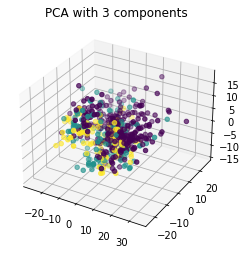

In [23]:
# PCA with 3 components
pca = PCA(n_components=3)

# fit the data (images) that is in the testset
pca_result = pca.fit_transform(test_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=[i[5] for i in uncertainties])
ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=[df['label']])
plt.title('PCA with 3 components')
plt.show()


In [24]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
pca = PCA(n_components=30)
pca_result = pca.fit_transform(test_data)
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=[df['label']])
plt.title('t-SNE')
plt.show()


Check how many correct and wrong prediction there were

In [ ]:
"""
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and worng predictions there are for each class
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in uncertainties:
    if i[4]:
        right[int(i[5])] += 1
    else:
        wrong[int(i[5])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])


# check how often which label was predicted and how often it was correct
pred = [0 for i in range(num_classes)]
correct = [0 for i in range(num_classes)]
for i in uncertainties:
    pred[int(i[6])] += 1
    if i[4]:
        correct[int(i[6])] += 1

for i in range(num_classes):
    print('Class', i, ' - Prediction ', class_names[i] , ' - ', 'Predicted:', pred[i], ' , ', 'of which were correct:', correct[i])
"""


'\nclass_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}\nclass_names = ["Normal", "Benign", "Malignant"]\n\n# count how many right and worng predictions there are for each class\nright = [0 for i in range(num_classes)]\nwrong = [0 for i in range(num_classes)]\nfor i in uncertainties:\n    if i[4]:\n        right[int(i[5])] += 1\n    else:\n        wrong[int(i[5])] += 1\n\nfor i in range(num_classes):\n    print(\'Class\', i, \' - \', class_names[i] , \' - \', \'Right:\', right[i], \' , \', \'Wrong:\', wrong[i])\n\n\n# check how often which label was predicted and how often it was correct\npred = [0 for i in range(num_classes)]\ncorrect = [0 for i in range(num_classes)]\nfor i in uncertainties:\n    pred[int(i[6])] += 1\n    if i[4]:\n        correct[int(i[6])] += 1\n\nfor i in range(num_classes):\n    print(\'Class\', i, \' - Prediction \', class_names[i] , \' - \', \'Predicted:\', pred[i], \' , \', \'of which were correct:\', correct[i])\n'

In [ ]:
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and wrong predictions there are for each class in the dataframe
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in range(len(df)):
    if df['pred'][i] == df['label'][i]:
        right[int(df['label'][i])] += 1
    else:
        wrong[int(df['label'][i])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])


Class 0  -  Normal  -  Right: 255  ,  Wrong: 30
Class 1  -  Benign  -  Right: 19  ,  Wrong: 111
Class 2  -  Malignant  -  Right: 35  ,  Wrong: 81


In [ ]:
# check how often which label was predicted and how often it was correct

pred = [0 for i in range(num_classes)]
correct = [0 for i in range(num_classes)]
for i in range(len(df)):
    pred[int(df['pred'][i])] += 1
    if df['pred'][i] == df['label'][i]:
        correct[int(df['pred'][i])] += 1

for i in range(num_classes):
    print('Class', i, ' - Prediction ', class_names[i] , ' - ', 'Predicted:', pred[i], ' , ', 'of which were correct:', correct[i])


Class 0  - Prediction  Normal  -  Predicted: 410  ,  of which were correct: 255
Class 1  - Prediction  Benign  -  Predicted: 28  ,  of which were correct: 19
Class 2  - Prediction  Malignant  -  Predicted: 93  ,  of which were correct: 35


### Uncertainty visualization

Normalized epistemic uncertainty

In [ ]:
def sort_uncertainties(u_type, normalized, uncertainties, as_tensor=False):
    
    # get the correct index at which the uncertainty is stored
    if u_type == 'epistemic':
        if normalized:
            u = 0
        else:
            u = 2
    elif u_type == 'aleatoric':
        if normalized:
            u = 1
        else:
            u = 3
    
    # split the testset into 5 groups based on epistemic uncertainty (normalized)
    testset0, testset1, testset2, testset3, testset4 = [], [], [], [], []
    labels0, labels1, labels2, labels3, labels4 = [], [], [], [], []

    # create thresholds 
    t0 = min([i[u] for i in uncertainties])
    t5 = max([i[u] for i in uncertainties])
    steps = (t5-t0) / 5

    t1 = t0 + steps
    t2 = t1 + steps
    t3 = t2 + steps
    t4 = t3 + steps

    for i, elem in enumerate(uncertainties):
        if elem[u] < t1:
            if as_tensor:
                testset0.append(testset[i][0])
                labels0.append([elem[5]])
            else:
                testset0.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels0.append(elem[5])
        elif elem[u] < t2:
            if as_tensor:
                testset1.append(testset[i][0])
                labels1.append([elem[5]])
            else:
                testset1.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels1.append(elem[5])
        elif elem[u] < t3:
            if as_tensor:
                testset2.append(testset[i][0])
                labels2.append([elem[5]])
            else:
                testset2.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels2.append(elem[5])
        elif elem[u] < t4:
            if as_tensor:
                testset3.append(testset[i][0])
                labels3.append([elem[5]])
            else:
                testset3.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels3.append(elem[5])
        else:
            if as_tensor:
                testset4.append(testset[i][0])
                labels4.append([elem[5]])
            else:
                testset4.append(testset[i][0].numpy().reshape(-1, 180*180).reshape(-1))
                labels4.append(elem[5])

    testsets = [testset0, testset1, testset2, testset3, testset4]
    thresholds = [t0, t1, t2, t3, t4, t5]
    labelssets = [labels0, labels1, labels2, labels3, labels4]
    vals = ["small", "small-medium", "medium", "medium-large", "large"]

    return testsets, thresholds, labelssets, vals


In [ ]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
def plot_tsne(uncertainties, u_type='epistemic', normalized=True):

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type, normalized, uncertainties)

    for i in range(len(testsets)):

        set_i = testsets[i]
        labels_i = labelssets[i]
        if len(set_i) > 2:
            if len(labels_i) < 30:
                n_components = len(labels_i)
            else:
                n_components = 30
            pca = PCA(n_components=n_components)
            pca_result = pca.fit_transform(set_i)
            tsne = TSNE(n_components=3)
            tsne_result = tsne.fit_transform(pca_result)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=labels_i)
            plt.title('t-SNE for ' + vals[i] + ' epistemic uncertainty (normalized) (between ' + str(thresholds[i]) + ' and ' + str(thresholds[i+1]) + ')')
            plt.show()
        else:
            print('too little data in this group to plot t-SNE')

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


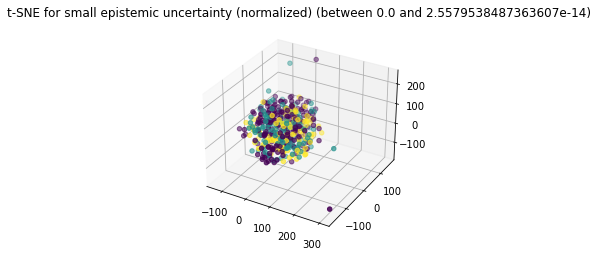

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


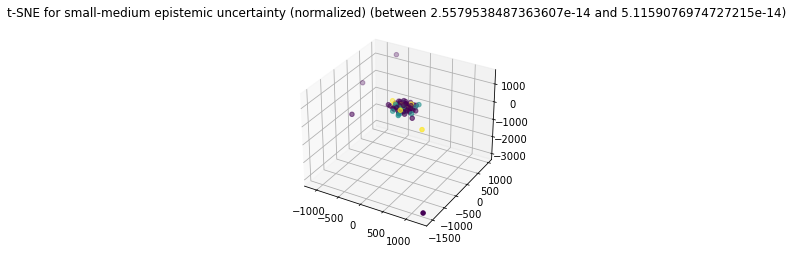

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


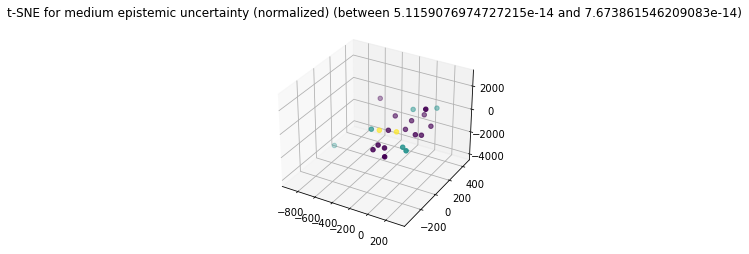

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


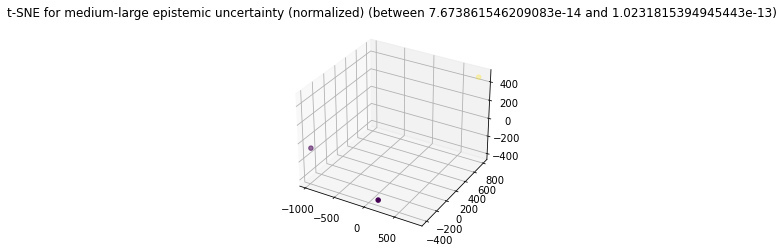

too little data in this group to plot t-SNE


In [ ]:
plot_tsne(uncertainties, u_type='epistemic', normalized=True)

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


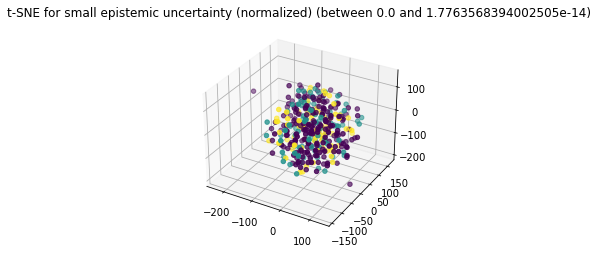

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


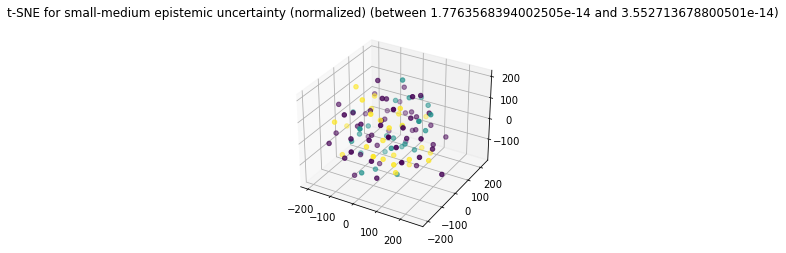

too little data in this group to plot t-SNE


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


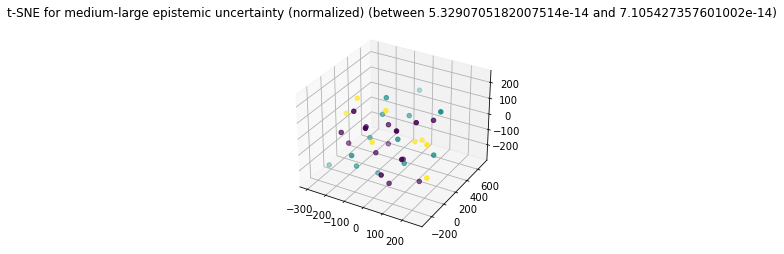

too little data in this group to plot t-SNE


In [ ]:
plot_tsne(uncertainties, u_type='epistemic', normalized=False)

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


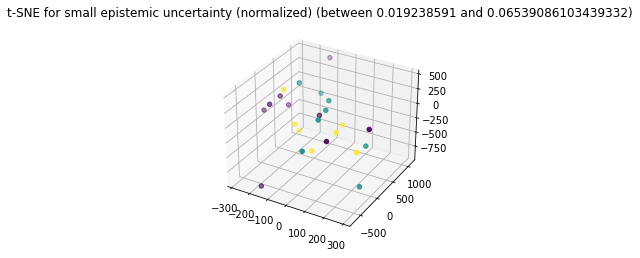

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


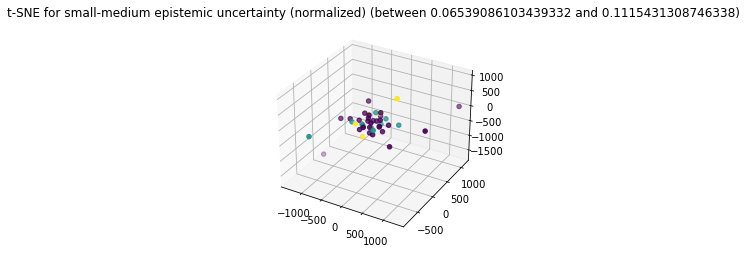

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


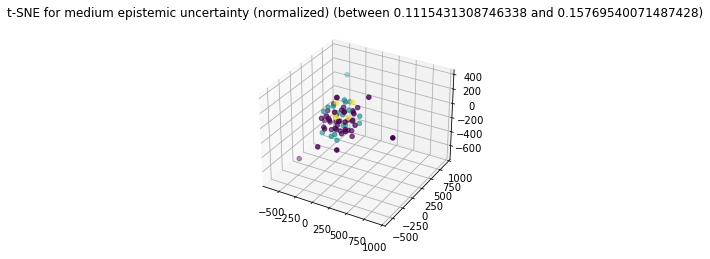

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


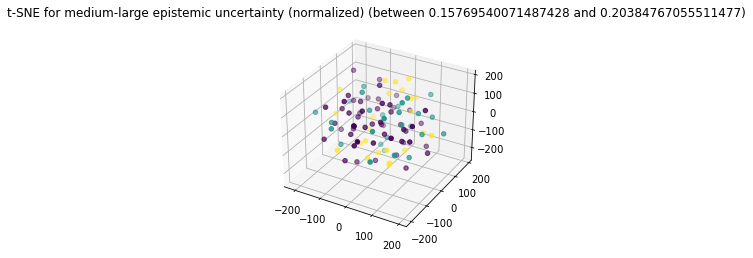

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


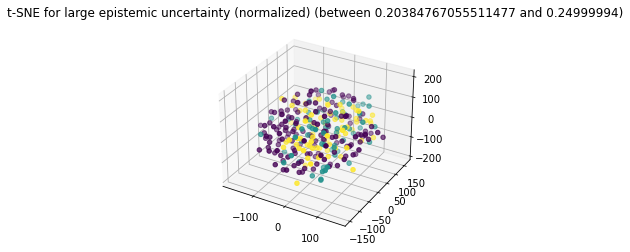

In [ ]:
plot_tsne(uncertainties, u_type='aleatoric', normalized=True)

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


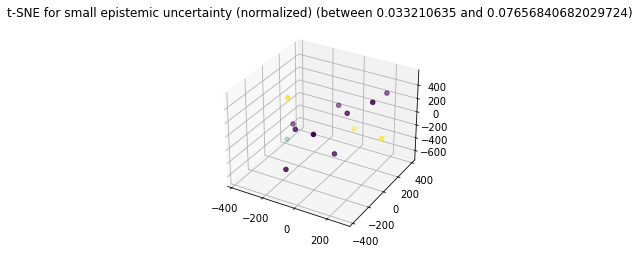

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


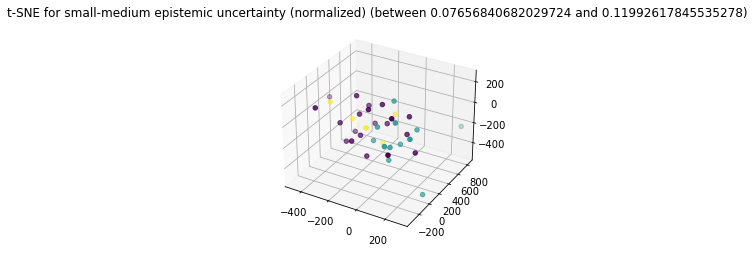

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


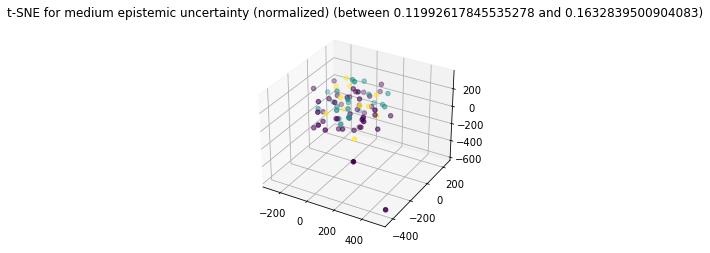

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


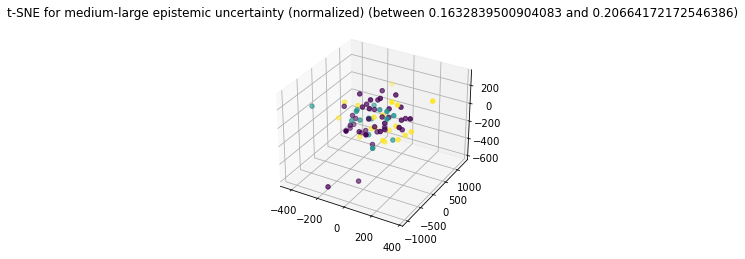

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


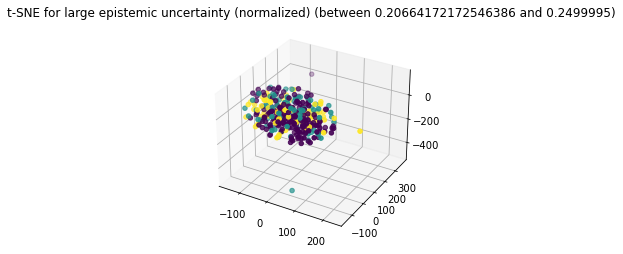

In [ ]:
plot_tsne(uncertainties, u_type='aleatoric', normalized=False)

Calculate the accuracy for the different subsets

In [ ]:
def validate_model(net, criterion, testset, labelsset, num_ens=30, beta_type=0.1, epoch=None, num_epochs=None):
    """Calculate accuracy and NLL Loss"""
    net.eval()
    valid_loss = 0.0
    accs = []
    print('number of images: ', len(testset))

    for i in range(len(testset)):
        inputs, labels = testset[i], labelsset[i]
        inputs, labels = inputs.to(device), labels.to(device)

        # add one dimension to the inputs
        inputs = inputs.unsqueeze(0)

        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)
        beta = metrics.get_beta(i-1, len(testset), beta_type, epoch, num_epochs)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(testset), np.mean(accs)

In [ ]:
def acc_by_uncertainty(u_type, normalized, uncertainties):

    vals = ["small", "small-medium", "medium", "medium-large", "large"]

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type=u_type, normalized=normalized, uncertainties=uncertainties, as_tensor=True)
    

    for i in range(len(testsets)):

        print('Evaluating for ' + vals[i] + ' uncertainties')

        set_i = testsets[i]
        labels_i = labelssets[i]

        # transform the data into a tensor
        labels_i = torch.tensor(labels_i)
        set_i = torch.stack(set_i)
        #print('set shape: ', set_i.shape)

        criterion = metrics.ELBO(len(set_i)).to(device)
        valid_loss, valid_acc = validate_model(net, criterion, set_i, labels_i, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None)

        print('Validation Loss: %.8f, Validation Accuracy: %.2f' % (valid_loss, valid_acc))



In [ ]:
acc_by_uncertainty(u_type='epistemic', normalized=True, uncertainties=uncertainties)

Evaluating for small uncertainties
number of images:  435
Validation Loss: 16643822.71954023, Validation Accuracy: 0.53
Evaluating for small-medium uncertainties
number of images:  70
Validation Loss: 16643439.91428571, Validation Accuracy: 0.49
Evaluating for medium uncertainties
number of images:  22
Validation Loss: 16643376.68181818, Validation Accuracy: 0.68
Evaluating for medium-large uncertainties
number of images:  3
Validation Loss: 16643360.66666667, Validation Accuracy: 1.00
Evaluating for large uncertainties
number of images:  1
Validation Loss: 16643359.00000000, Validation Accuracy: 1.00


In [ ]:
acc_by_uncertainty(u_type='epistemic', normalized=False, uncertainties=uncertainties)


Evaluating for small uncertainties
number of images:  385
Validation Loss: 16643768.78701299, Validation Accuracy: 0.53
Evaluating for small-medium uncertainties
number of images:  107
Validation Loss: 16643480.97196262, Validation Accuracy: 0.47
Evaluating for medium uncertainties


RuntimeError: stack expects a non-empty TensorList

In [ ]:
acc_by_uncertainty(u_type='aleatoric', normalized=True, uncertainties=uncertainties)


Evaluating for small uncertainties
number of images:  2
Validation Loss: 17824669.00000000, Validation Accuracy: 0.50
Evaluating for small-medium uncertainties
number of images:  7
Validation Loss: 17824675.14285714, Validation Accuracy: 0.43
Evaluating for medium uncertainties
number of images:  53
Validation Loss: 17824719.88679245, Validation Accuracy: 0.55
Evaluating for medium-large uncertainties
number of images:  141
Validation Loss: 17824838.66666667, Validation Accuracy: 0.46
Evaluating for large uncertainties
number of images:  328
Validation Loss: 17824964.63414634, Validation Accuracy: 0.60


In [ ]:
acc_by_uncertainty(u_type='aleatoric', normalized=False, uncertainties=uncertainties)


Evaluating for small uncertainties
number of images:  2
Validation Loss: 17824668.00000000, Validation Accuracy: 1.00
Evaluating for small-medium uncertainties
number of images:  6
Validation Loss: 17824670.00000000, Validation Accuracy: 0.83
Evaluating for medium uncertainties
number of images:  22
Validation Loss: 17824680.90909091, Validation Accuracy: 0.82
Evaluating for medium-large uncertainties
number of images:  118
Validation Loss: 17824762.50847458, Validation Accuracy: 0.63
Evaluating for large uncertainties
number of images:  383
Validation Loss: 17825104.37075718, Validation Accuracy: 0.49


Plot PCA for different subsets

In [ ]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
def plot_pca(uncertainties, u_type='epistemic', normalized=True):

    testsets, thresholds, labelssets, vals = sort_uncertainties(u_type, normalized, uncertainties)

    for i in range(len(testsets)):
        set_i = testsets[i]
        labels_i = labelssets[i]

        if len(set_i) > 2:
            
            # PCA with 3 components
            pca = PCA(n_components=3)

            # fit the data (images) that is in the testset
            pca_result = pca.fit_transform(set_i)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(xs=[i[0] for i in pca_result], ys=[i[1] for i in pca_result], zs=[i[2] for i in pca_result], c=labels_i)
            plt.title('PCA for ' + vals[i] + ' epistemic uncertainty (normalized) (between ' + str(thresholds[i]) + ' and ' + str(thresholds[i+1]) + ')')
            plt.show()

        else:
            print("Not enough data points to plot PCA")

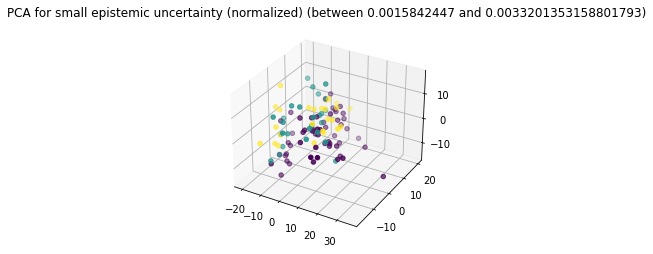

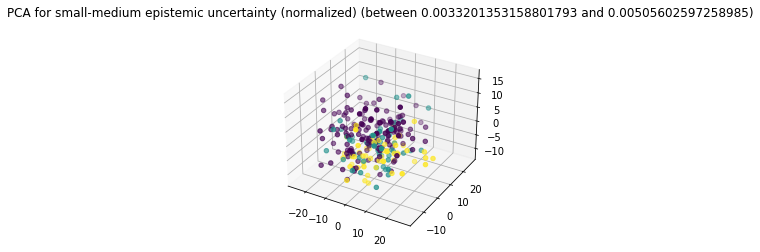

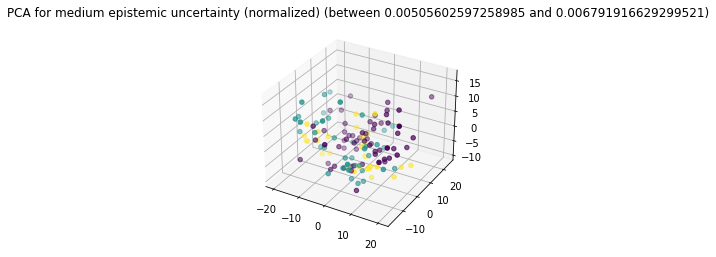

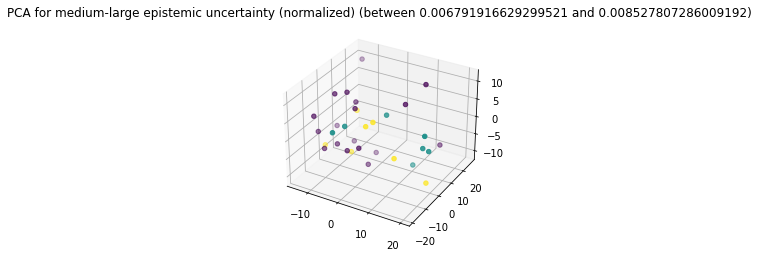

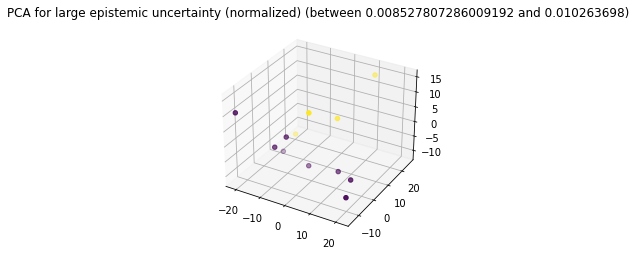

In [ ]:
plot_pca(uncertainties, u_type='epistemic', normalized=True)

# Inspect different subgroups in the data

### Subgroups based on uncertainty

### Subgroups based on class

## Testing the augmentation functionalities

In [ ]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt


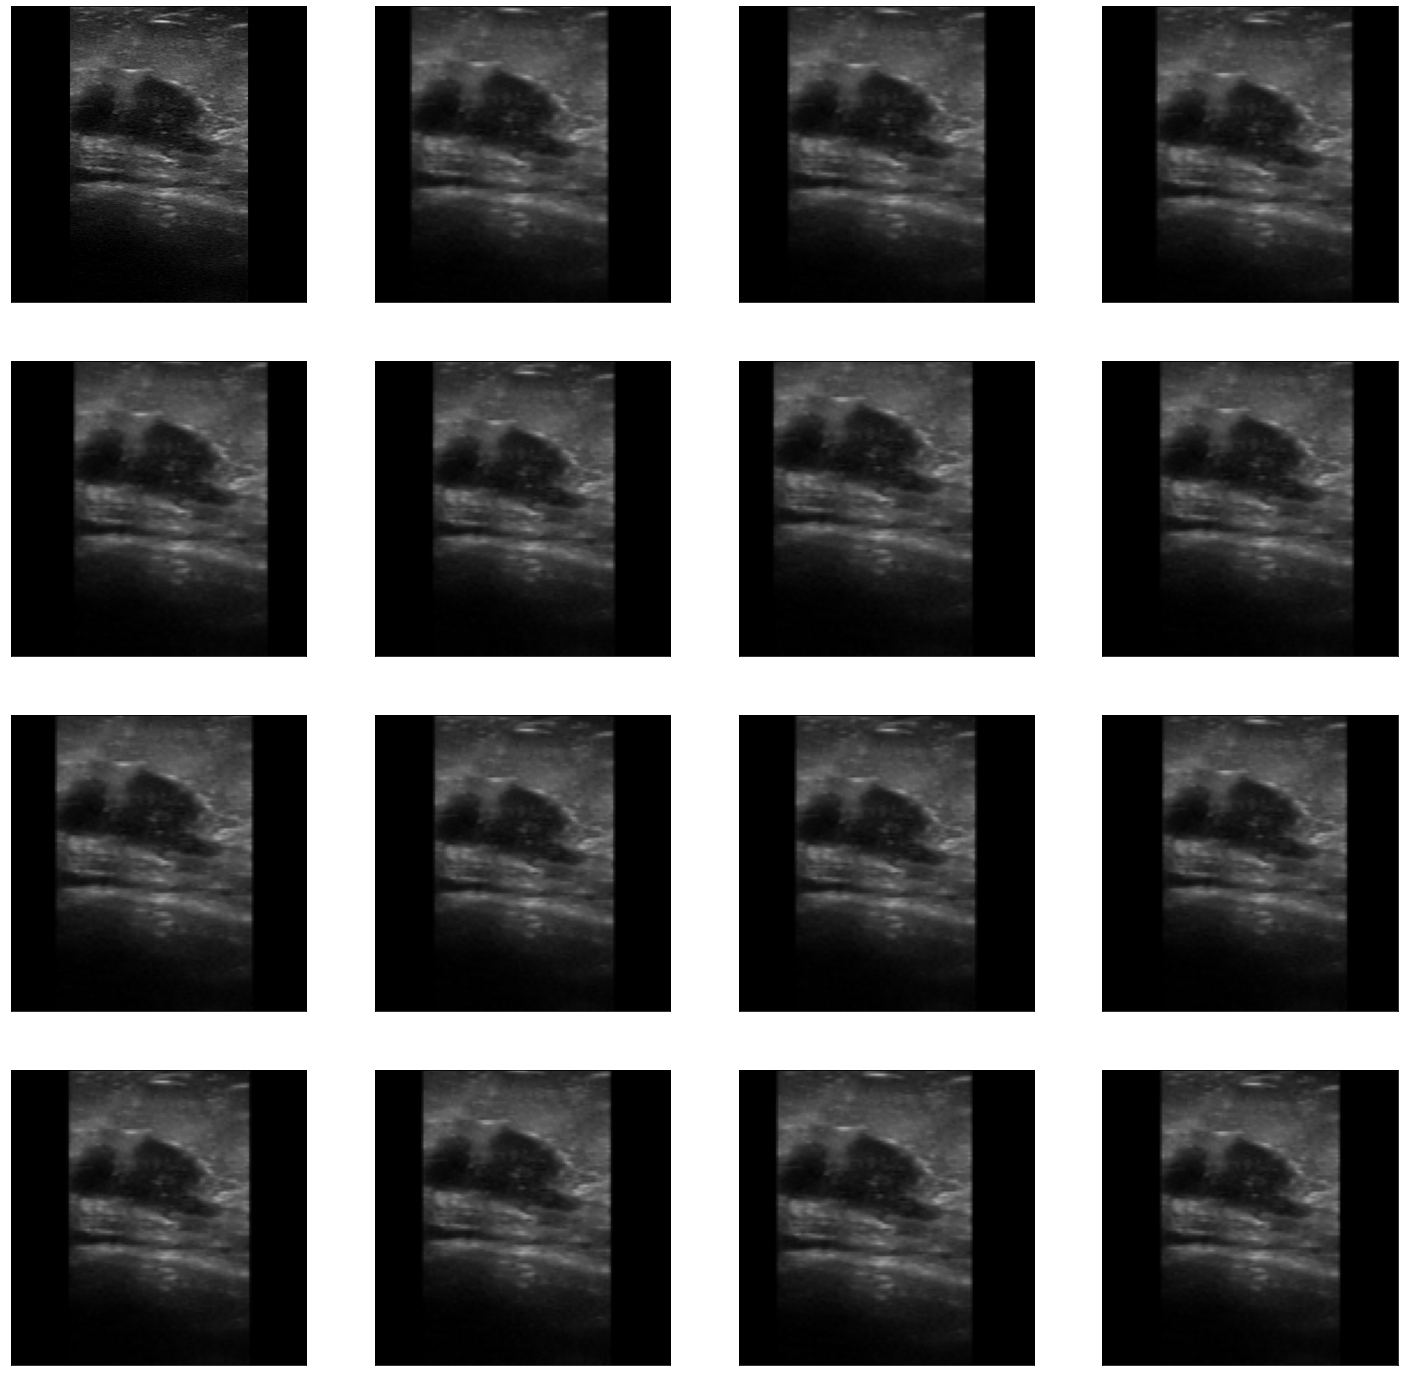

In [ ]:
img = Image.open('/home/marisa/Documents/Thesis/Data/POCUS/Test/Malignant/002M_9.jpg')
transform = transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(1.0, 1.0))

imgs = [transform(img) for _ in range(15)]
fig = plt.figure(figsize=(25,25))
rows, cols = 4,4
fig.add_subplot(rows, cols, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
for j in range(0, len(imgs)):
   fig.add_subplot(rows, cols, j+2)
   plt.imshow(imgs[j])
   plt.xticks([])
   plt.yticks([])
plt.show()

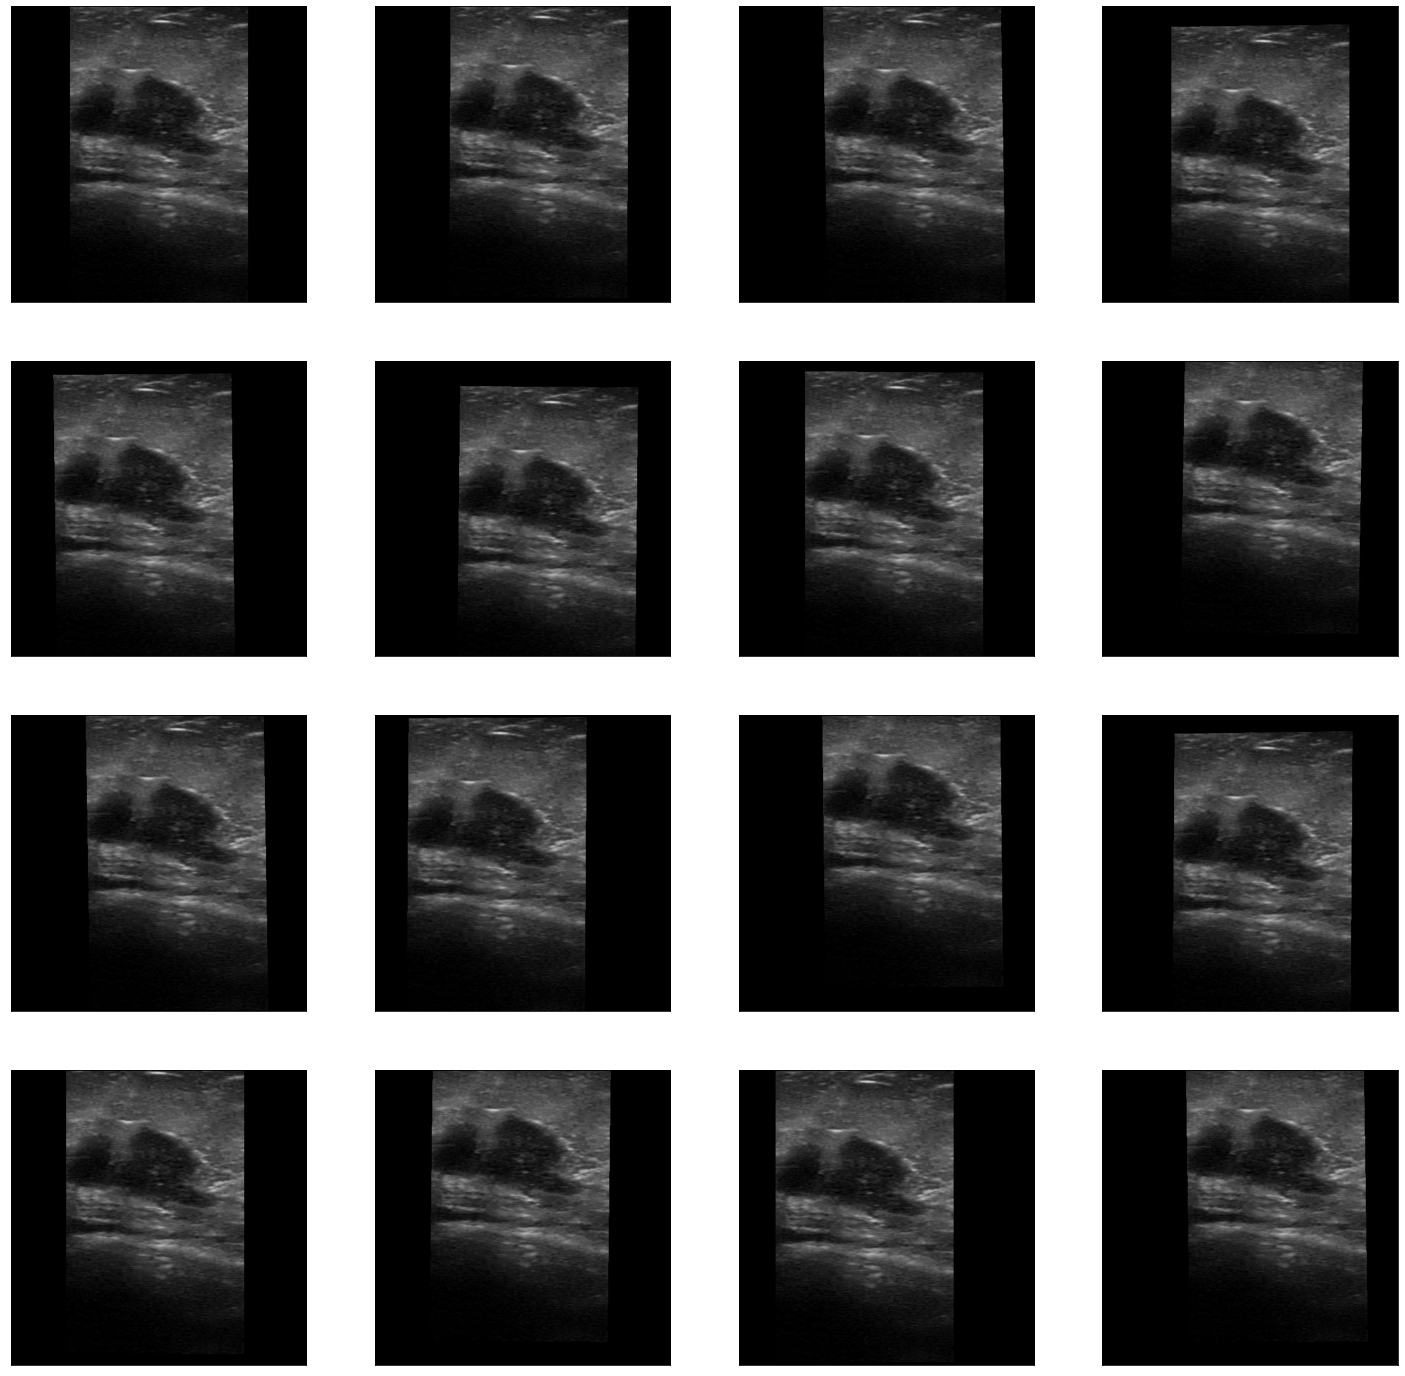

In [ ]:
img = Image.open('/home/marisa/Documents/Thesis/Data/POCUS/Test/Malignant/002M_9.jpg')
transform = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=(-1.0,1.0,-1.0,1.0))

imgs = [transform(img) for _ in range(15)]
fig = plt.figure(figsize=(25,25))
rows, cols = 4,4
fig.add_subplot(rows, cols, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
for j in range(0, len(imgs)):
   fig.add_subplot(rows, cols, j+2)
   plt.imshow(imgs[j])
   plt.xticks([])
   plt.yticks([])
plt.show()



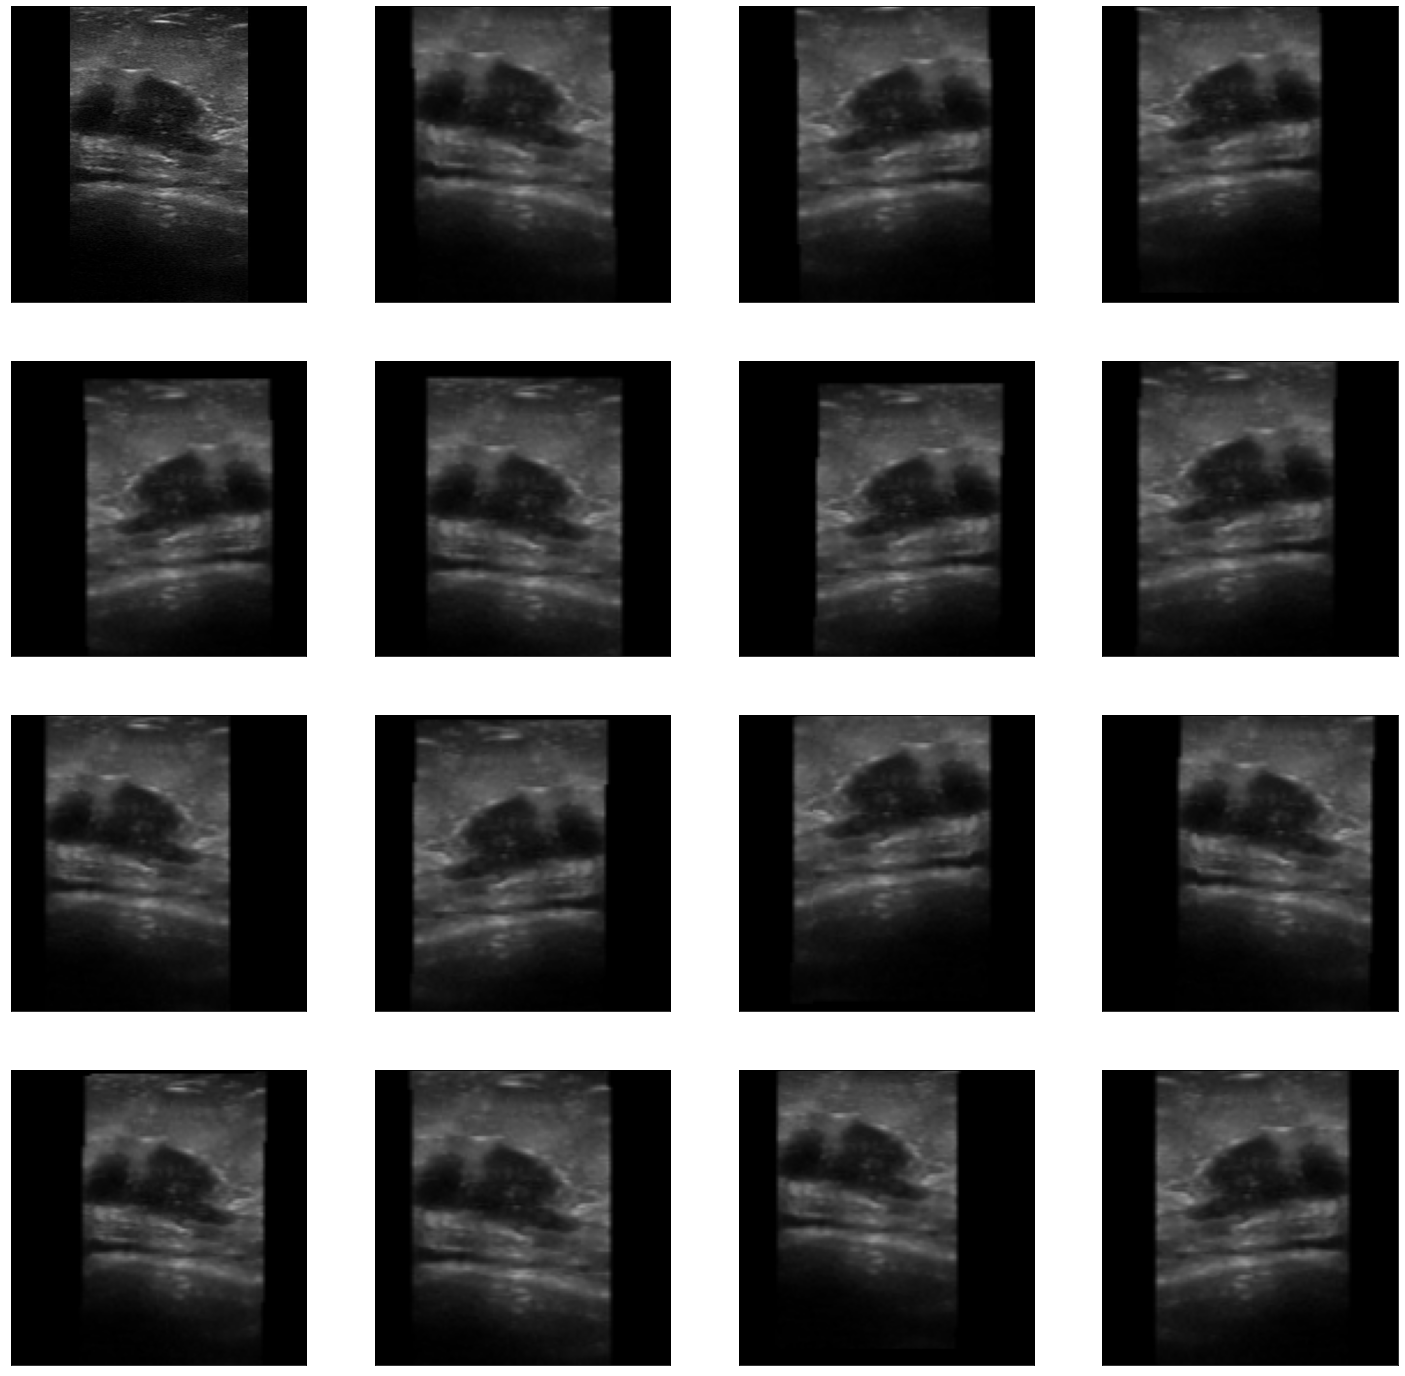

In [ ]:
img = Image.open('/home/marisa/Documents/Thesis/Data/POCUS/Test/Malignant/002M_9.jpg')
transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((128, 128)), # 180x180 is the originally used size of the input images
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=(-1.0,1.0,-1.0,1.0)), # verical and horizontal shift range 0.1, shear range 0.1
        # TODO: test if scale and ratio are doing the correct thing
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(1.0, 1.0)), # crop 128x128, scale 0.8-1.0, ratio 1-1 (for square crop)
        transforms.RandomHorizontalFlip(),
        ])

imgs = [transform(img) for _ in range(15)]
fig = plt.figure(figsize=(25,25))
rows, cols = 4,4
fig.add_subplot(rows, cols, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
for j in range(0, len(imgs)):
   fig.add_subplot(rows, cols, j+2)
   plt.imshow(imgs[j])
   plt.xticks([])
   plt.yticks([])
plt.show()



